# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

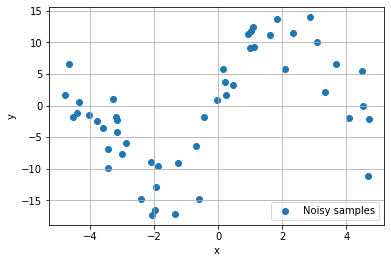

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

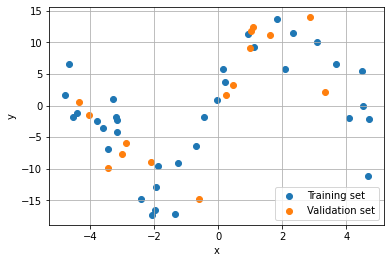

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

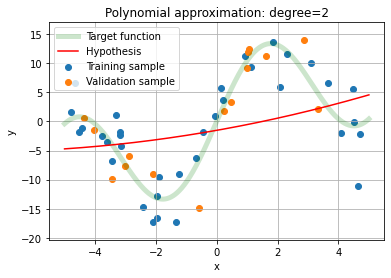

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

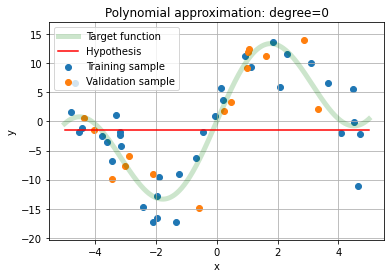

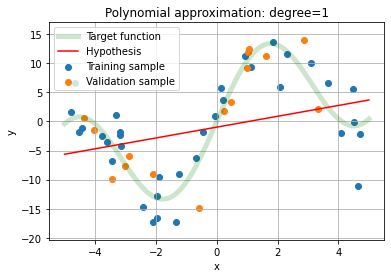

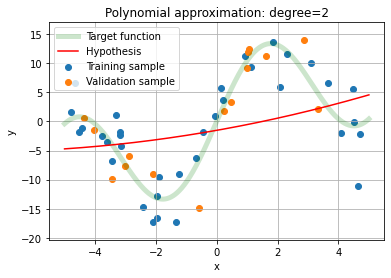

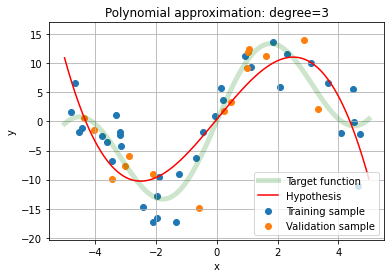

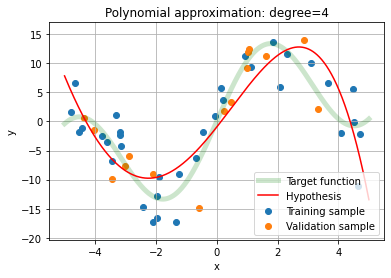

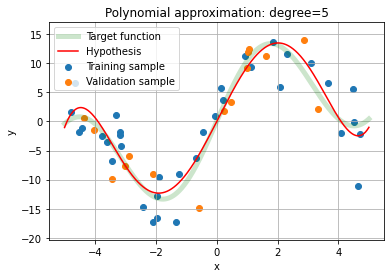

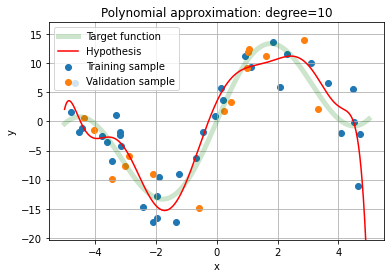

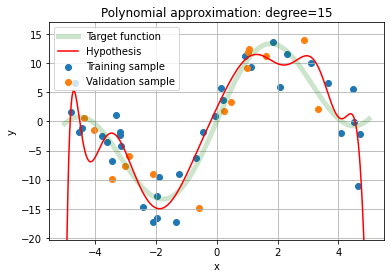

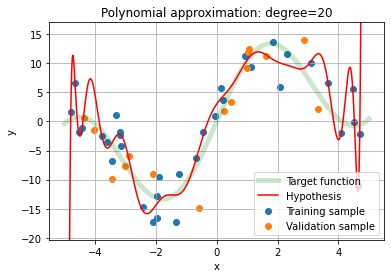

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

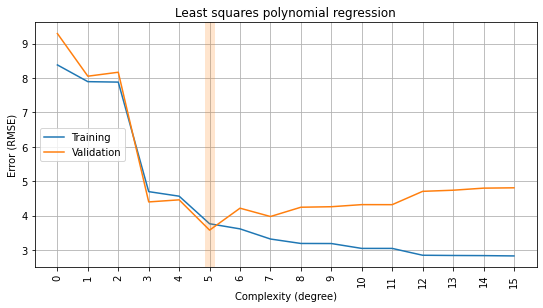

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

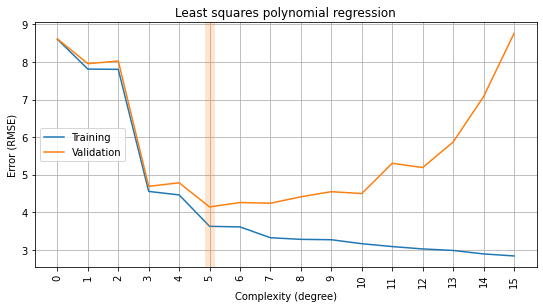

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

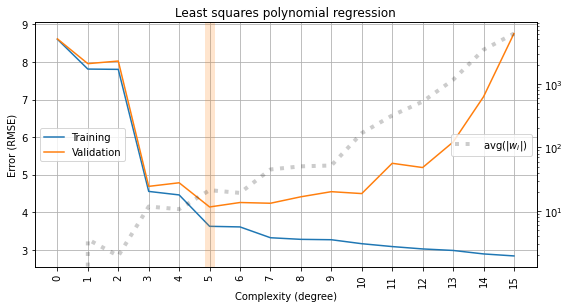

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

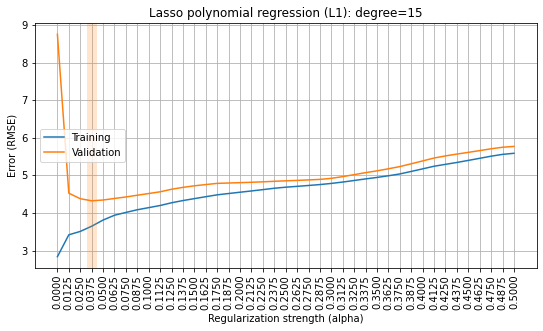

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

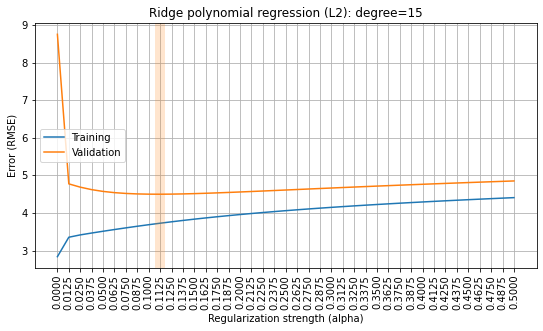

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

Let's select **first 5 features** for future transformation.

In [117]:
pol_features = X_diabetes.columns.tolist()[:5]
pol_features

['age', 'sex', 'bmi', 'bp', 's1']

In [118]:
from sklearn.compose import ColumnTransformer

def make_model_2(pol_features, degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    column_transformer = ColumnTransformer(transformers=[
        ('PolynomialFeatures', 
        PolynomialFeatures(degree, include_bias=(degree == 0)), 
        pol_features)
    ], remainder='passthrough')
    
    return Pipeline([
        ('pol', column_transformer),
        ('reg', regressor)
    ])

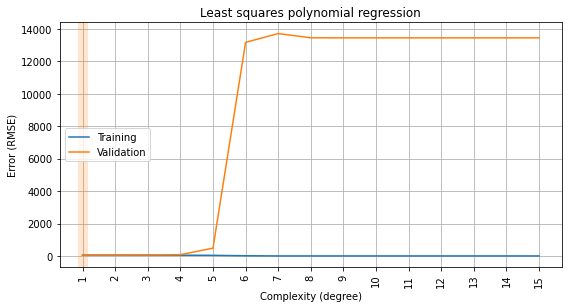

In [119]:
rmse_train, rmse_valid = [], []
for degree in DEGREES[1:]:
    results = cross_validate(make_model_2(pol_features, degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

Let's look closer at our graph taking degrees from 1 to 4 inclusively.

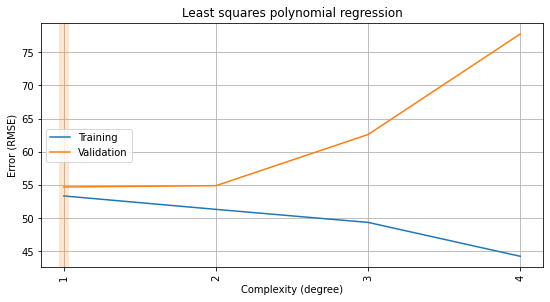

In [509]:
rmse_train, rmse_valid = [], []
for degree in DEGREES[1:5]:
    results = cross_validate(make_model_2(pol_features, degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES[1:5], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

What do we see at the graph above:

1. **Fit is just right**: Starts with the **degree of 1**. The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.
 
2. **Underfitting**: is not observed.

3. **Overfitting** (degree > 2): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

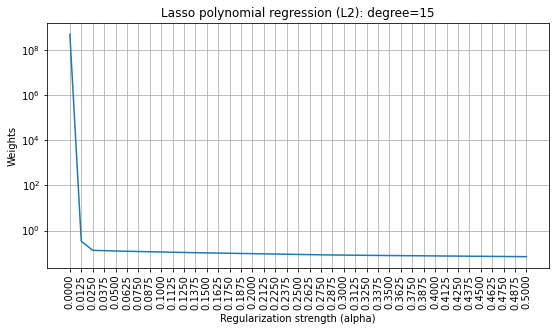

In [568]:
avg_coef_L1 = []
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_2(pol_features, degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5, 
                             return_estimator=True, return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    avg_coef_L1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
    
def plot_weights(x, y, title, xlabel='Regularization strength (alpha)', ylabel='Weights'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')   
    plt.yscale('log')
    
plot_weights(ALPHAS, avg_coef_L1, title='Lasso polynomial regression (L2): degree=15')

#### L2

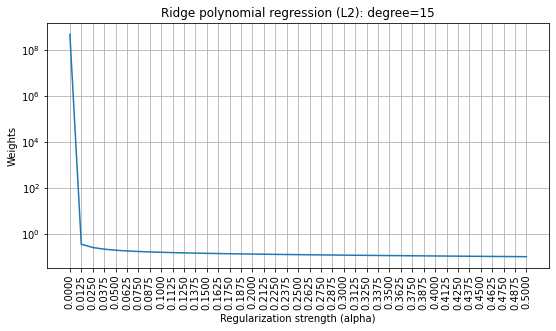

In [569]:
avg_coef_L2 = []
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_2(pol_features, degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5, 
                             return_estimator=True, return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    avg_coef_L2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_weights(ALPHAS, avg_coef_L2, title='Ridge polynomial regression (L2): degree=15')

Let's compare Lasso and Ridge average weights' decreasing with alpha's increasing. We'll ignore **alpha = 0** because it 's **linear regression** and our results wouldn't be appropriate enough. Also we'll omit coresponding coefficients both from average weights for Lasso and Ridge regressions.

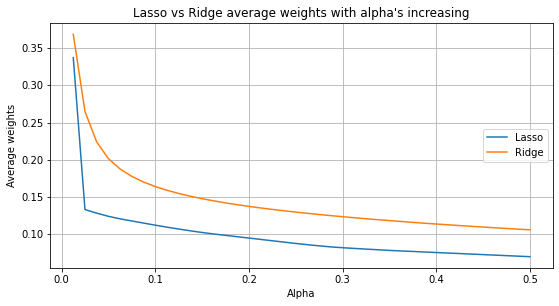

In [571]:
plt.figure(figsize=(9,4.5))
plt.plot(ALPHAS[1:], avg_coef_L1[1:], label='Lasso')
plt.plot(ALPHAS[1:], avg_coef_L2[1:], label='Ridge')
plt.title("Lasso vs Ridge average weights with alpha's increasing")
plt.xlabel('Alpha')
plt.ylabel('Average weights')
plt.grid(True)
plt.legend(loc='center right')  
plt.show()

#### Summary

As empirically observed above, if we use regularization methods both for Lasso and Ridge regularizations weights values fall down significantly(**at alpha of 0.0125**) compared to alpha of 0 (point of no regularization applied). Besides with alpha's increasing average weights of Lasso are smaller than Ridge.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [572]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

In [636]:
coef_L1 = []
for alpha in ALPHAS:
    result = make_model_2(pol_features, degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)
    coef_L1.append(result['reg'].coef_)

In [651]:
def estimate_zero_coef(L, coef, yscale, display_zero_df=False):
    n = coef[0].shape[1]
    N = len(coef) * n
    
    non_zero_for_alpha = np.array([np.count_nonzero(coef[i]) for i in range (0,41)])
    zero_count_for_alpha = n - non_zero_for_alpha
    zero_percentage_for_alpha = zero_count_for_alpha * 100 / n
    
    plt.figure(figsize=(9,4.5))
    plt.plot(ALPHAS, zero_percentage_for_alpha, label='weights')   
    plt.title(f'Percentage of zero weights according to each alpha ({L} polynomial regression: degree=15)')
    plt.xlabel('Regularization strength (alpha)')
    plt.ylabel('Percentage of zero weights')
    plt.yscale(yscale)
    plt.xticks(ALPHAS, rotation='vertical')
    plt.grid(True)
    plt.show()
    
    zero_sum = N - np.sum(non_zero_for_alpha)
    print(f"Amount of zero coef in {L} regularization: {zero_sum} which is: {zero_sum * 100/ N} %")
    
    if display_zero_df is True:
        df = pd.DataFrame(ALPHAS, columns=['alpha'])
        df['percentage_of_zero'] = zero_percentage_for_alpha
        display(df)

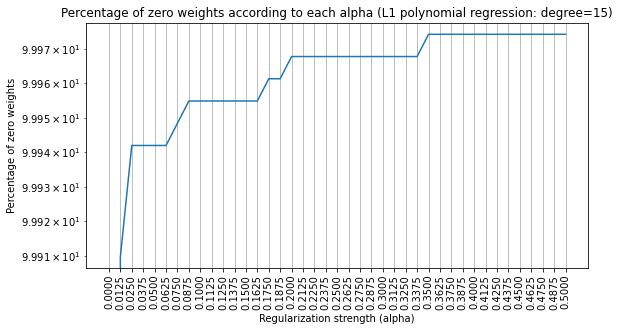

Amount of zero coef in L1 regularization: 620089 which is: 97.52464502978793 %


,alpha,percentage_of_zero
0,0.0000,0.000000
1,0.0125,99.909724
2,0.0250,99.941965
3,0.0375,99.941965
4,0.0500,99.941965
5,0.0625,99.941965
6,0.0750,99.948414
7,0.0875,99.954862
8,0.1000,99.954862
9,0.1125,99.954862


In [652]:
estimate_zero_coef('L1', coef_L1, yscale='log', display_zero_df=True)

#### L2

In [638]:
coef_L2 = []
for alpha in ALPHAS:
    result = make_model_2(pol_features, degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)
    coef_L2.append(result['reg'].coef_)

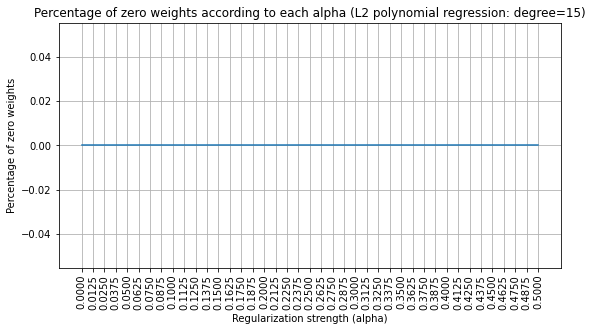

Amount of zero coef in L2 regularization: 0 which is: 0.0 %


In [653]:
estimate_zero_coef('L2', coef_L2, yscale='linear')

#### Summary

As we saw above, Lasso can also be used for feature selection since L1 is more likely to produce zero coefficients. For Lasso: at **alpha of 0.0125** percentage of zero coefficients is **greater than 99.9%**  while for Ridge - **0% for each alpha**.

- Lasso excludes useless variables - keeps one of the correlated predictors with larger coefficient on target.
- Ridge shrinks coefficients of correlated predictors in range small values, very close to zero, but not exactly equal to zero.
- Lasso is better to use when we have a small amount of significant predictors, that really affect our target.
- Ridge tends to do a little better when most variables are usefull.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [299]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


Let's define two models: scaled and non-scaled.

In [706]:
def make_model_scaled(alpha=alpha, penalty=None):
    if penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(penalty='L1', alpha=0.5))
display(make_model(penalty='L2', alpha=0.5))


def make_model_non_scaled(alpha=alpha, penalty=None):
    if penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    return Pipeline([
        ('reg', regressor)
    ])

display(make_model_non_scaled(penalty='L1', alpha=0.5))
display(make_model_non_scaled(penalty='L2', alpha=0.5))

Pipeline(steps=[('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.5, max_iter=50000, random_state=42))])

Pipeline(steps=[('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.5, max_iter=50000, random_state=42))])

Pipeline(steps=[('reg', Lasso(alpha=0.5, max_iter=50000, random_state=42))])

Pipeline(steps=[('reg', Ridge(alpha=0.5, max_iter=50000, random_state=42))])

In [707]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

#### L1

Let's see how Lasso regression performs on non-scaled input data.

In [773]:
def estimate_scaling(L, model):

    ALPHAS = np.linspace(0.0125, 0.5, 1 + 40)
    rmse_train, rmse_valid, coef = [], [], []


    for alpha in ALPHAS:
        reg = model(alpha, penalty=L).fit(X_train, y_train)
        rmse_train.append(rmse(reg.predict(X_train), y_train))
        rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
        coef.append(reg['reg'].coef_)

    plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                       xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                       title=f'{L} regression')
    
    print (f'Min rmse error for test set is {min(rmse_valid):.2f}')
    
    N = len(coef) * coef[0].shape[0]
    zero_percentage = (N - np.count_nonzero(coef)) * 100 / N
    print (f'Zero coef percentage is: {zero_percentage:.2f}%')
    
    print(f'Max value of coeffitients: {np.max(coef):.2f}, min value of coeffitients: {np.min(coef):.2f}')

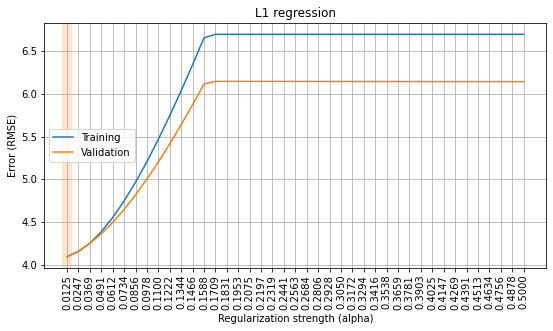

Min rmse error for test set is 4.09
Zero coef percentage is: 22.76%
Max value of coeffitients: 162.74, min value of coeffitients: -0.03


In [774]:
estimate_scaling('L1', model=make_model_non_scaled)

Now we'll see the performance of Lasso with scaled data.

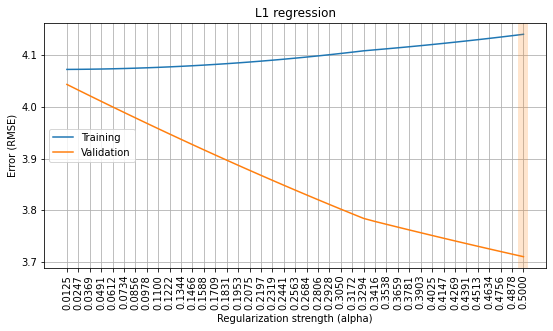

Min rmse error for test set is 3.71
Zero coef percentage is: 11.38%
Max value of coeffitients: 5.32, min value of coeffitients: -1.33


In [775]:
estimate_scaling('L1', model=make_model_scaled) 

#### L2

Let's do the same research for Ridge regression.

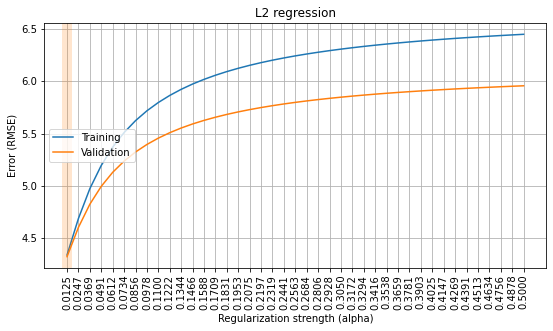

Min rmse error for test set is 4.32
Zero coef percentage is: 0.00%
Max value of coeffitients: 126.69, min value of coeffitients: -0.03


In [776]:
estimate_scaling('L2', model=make_model_non_scaled)

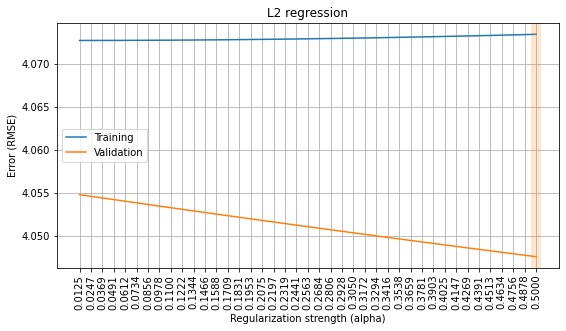

Min rmse error for test set is 4.05
Zero coef percentage is: 0.00%
Max value of coeffitients: 5.33, min value of coeffitients: -1.34


In [777]:
estimate_scaling('L2', model=make_model_scaled)

#### Summary



Comparing models with and without scaling we may summarize:

- RMSE for valid sets decreased with applying scaling to input data. That means our model became better and we got rid of unnecessary noise.
- Amount of zero coefficients for Lasso regression is less when we standardize the data. We might notice that max value of coeffitients both for L1 and L2 is also significantly less when we use scaling. So without scaling we may confused which features are less important to our target and L1 turned big coeffitients to zero. So features need to be on the same scale for its appropriate selection.